## Macro-Financial variables and Returns

In this project, we investigate how major macro-financial variables influence the daily returns of the U.S. stock market.
Using data collected through the yfinance API, we analyze a set of key economic indicators — Treasury yields, crude oil prices, the U.S. Dollar Index, and gold prices — together with the S&P 500 index, taken as the benchmark for the equity market.

### Treasury Yield (10-Year) $\Rightarrow$ Yield
The 10-year Treasury yield is one of the most important indicators of macroeconomic and financial conditions.
It reflects expectations about inflation, monetary policy, and economic growth.
Changes in yields influence equity valuations through discount rates, and therefore they are often associated with movements in the stock market.

### Crude Oil Prices (WTI) $\Rightarrow$ Oil
Crude oil is a key global commodity closely tied to economic activity, production costs, and inflationary pressures.
Short-term fluctuations in oil prices can signal changes in global demand or supply shocks, which may immediately affect equity markets and corporate profitability.
Because of its economic relevance, oil returns are included to capture commodity-driven components of market movement.

### U.S. Dollar Index $\Rightarrow$ Dollar
The U.S. Dollar Index measures the value of the U.S. dollar against a basket of major international currencies.
Daily changes in the dollar often reflect shifts in risk sentiment, international capital flows, and monetary expectations.
A stronger dollar can weigh on multinational companies' earnings, while a weaker one can boost export competitiveness, making the dollar an important macro-financial regressor.

### Gold Prices $\Rightarrow$ Gold
Gold is traditionally considered a “safe-haven” asset, meaning that it tends to appreciate during periods of financial uncertainty or market stress.
Its returns often move inversely to those of equities and interest rates, capturing the risk-off component of market dynamics.
Including gold allows the model to account for flight-to-quality behavior in financial markets.

### Berkshire Hathaway (BRK-B) $\Rightarrow$ Berkshire
Berkshire Hathaway is one of the largest diversified holding companies in the United States, with investments spanning insurance, energy, manufacturing, consumer goods, and financial services.
Its stock price is often viewed as a proxy for broad U.S. economic fundamentals and long-term value investing.
Because of its strong ties to real economic activity and its stable market behavior, Berkshire returns help capture additional market-wide information not fully reflected by macro variables alone.

### Dependent Variable: S&P 500 Returns $\Rightarrow$ SP500
The S&P 500 index represents the performance of the U.S. equity market as a whole.
Using its daily log-returns as the dependent variable allows us to model short-term market fluctuations and evaluate how macroeconomic and financial factors contribute to daily movements in stock prices.

> Although the S&P 500 log-return is the dependent variable of the regression, it is included in the main dataset to simplify the computation of log-returns, correlation analysis, and exploratory data visualizations.
The full returns DataFrame contains all variables, but when building the regression model we explicitly separate the dependent variable (SP500) from the independent regressors.
This structure ensures a cleaner workflow while keeping the model specification correct.

## Work

The analysis covers the period from 2015 to 2025 and begins by computing daily log-returns for all assets in order to work with stationary, scale-independent series. We then estimate a multiple linear regression model where the S&P 500 log-return is the dependent variable, and the four macro-financial variables serve as regressors. The model is fitted using Ordinary Least Squares (OLS) to quantify the direction and magnitude of each variable’s impact on stock market movements.

To better understand the structure of the data, we examine the correlation matrix among all variables and visualize it through a heatmap. We further assess model adequacy by inspecting the residuals versus fitted values plot, which helps identify potential violations of OLS assumptions. Finally, we compute the Variance Inflation Factors (VIF) to evaluate multicollinearity among regressors and verify the stability of coefficient estimates.

Overall, this work provides an empirical assessment of how daily changes in interest rates, commodity prices, and currency dynamics are associated with fluctuations in the U.S. equity market. The results offer useful insights into the macro-financial forces that contribute to short-term market behavior.

## Import e download dei dati

This block imports all the necessary libraries for data collection, manipulation, visualization, and statistical modeling.
We define a set of financial market tickers, including the S&P 500 index, Treasury yields, crude oil prices, the U.S. Dollar Index, and gold futures.

Using the yfinance API, we download daily historical price data for the period 2015–2025.
The Close prices are then extracted from the downloaded dataset, forming the basis for the return calculations used in the regression analysis.

Finally, the first rows of the dataset are displayed to verify that the data has been downloaded correctly.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Symbols:
# ^GSPC = S&P500
# ^TNX  = 10yr Treasury Yield
# CL=F  = Crude Oil WTI
# DX-Y.NYB = Dollar Index (DXY)
# GC=F = Gold Futures

tickers = ["^GSPC", "^TNX", "CL=F", "DX-Y.NYB", "GC=F", "BRK-B"]
data: pd.DataFrame | None = yf.download(
    tickers, start="2015-01-01", end="2025-01-01", progress=False
)

assert data is not None
close = data["Close"]
print(close.head())

/tmp/ipykernel_3133/511828102.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data: pd.DataFrame | None = yf.download(


Ticker           BRK-B       CL=F   DX-Y.NYB         GC=F        ^GSPC   ^TNX
Date                                                                         
2015-01-02  149.169998  52.689999  91.080002  1186.000000  2058.199951  2.123
2015-01-05  147.000000  50.040001  91.379997  1203.900024  2020.579956  2.039
2015-01-06  146.839996  47.930000  91.500000  1219.300049  2002.609985  1.963
2015-01-07  148.880005  48.650002  91.889999  1210.599976  2025.900024  1.954
2015-01-08  151.369995  48.790001  92.370003  1208.400024  2062.139893  2.016


## Pulizia dati e costruzione variabili

This block computes daily log-returns for all selected financial time series.
We first calculate the ratio between each asset’s closing price and its previous day value, and then apply the natural logarithm to obtain log-returns.

The resulting data is explicitly converted into a pandas DataFrame and cleaned by removing missing values.
To improve readability, the columns are renamed according to the corresponding economic variables: oil prices, dollar index, gold prices, the S&P 500, and Treasury yields.

Finally, the first rows of the returns dataset are printed to confirm that the transformation was applied correctly.

In [2]:
# log-returns giornalieri
ratio = close / close.shift(1)
log_ratio = np.log(ratio)

# Cast esplicito per Pylance
returns = pd.DataFrame(log_ratio).dropna()

# Rinomino le colonne: CL=F, DX-Y.NYB, GC=F, ^GSPC, ^TNX, BRK-B
returns.columns = ["Oil", "Dollar", "Gold", "SP500", "Yield", "Berkshire"]

print(returns.head())

                 Oil    Dollar      Gold     SP500     Yield  Berkshire
Date                                                                   
2015-01-05 -0.014654 -0.051603  0.003288  0.014980 -0.018447  -0.040371
2015-01-06 -0.001089 -0.043081  0.001312  0.012711 -0.008933  -0.037986
2015-01-07  0.013797  0.014910  0.004253 -0.007161  0.011563  -0.004595
2015-01-08  0.016586  0.002874  0.005210 -0.001819  0.017730   0.031237
2015-01-09 -0.012631 -0.008852 -0.004666  0.006270 -0.008439  -0.022574


/home/mattegiorgi/docs/rts/.venv/lib/python3.11/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


## Definizione della regressione

In this block, we set up and estimate the multiple linear regression model. The daily log-returns of the S&P 500 index are selected as the dependent variable.

The independent variables include changes in Treasury yields, oil prices, the U.S. Dollar Index, and gold prices, representing key macro-financial factors.

An intercept term is added to the design matrix, and the model is fitted using Ordinary Least Squares (OLS) via the statsmodels library.
The regression summary is printed to provide coefficient estimates, significance levels, and overall model diagnostics.

$$
R_{\mathrm{SP500},t} = \beta_0 + \beta_1 \Delta\mathrm{Yield}_t + \beta_2 \Delta\mathrm{Oil}_t + \beta_3 \Delta\mathrm{Dollar}_t + \beta_4 \Delta\mathrm{Gold}_t + u_t
$$

In [3]:
# variabile dipendente: rendimento S&P500
y = returns["SP500"]

# regressori: tasso, petrolio, dollar index, oro
X = returns[["Yield", "Oil", "Dollar", "Gold", "Berkshire"]]

# aggiungo l'intercetta
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  SP500   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     134.9
Date:                Tue, 18 Nov 2025   Prob (F-statistic):          7.09e-127
Time:                        11:01:46   Log-Likelihood:                 8486.3
No. Observations:                2506   AIC:                        -1.696e+04
Df Residuals:                    2500   BIC:                        -1.693e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      2.317      0.0

## Heatmap delle correlazioni

This block computes and visualizes the correlation matrix of all log-return series.
The corr() function is used to quantify linear relationships between the S&P 500 returns and the selected macro-financial variables.

A heatmap is then generated using Seaborn to provide a clear and intuitive graphical representation of the correlation structure.

The color scale helps highlight positive and negative correlations, offering useful insights into the interdependencies among the variables before running more advanced diagnostics.

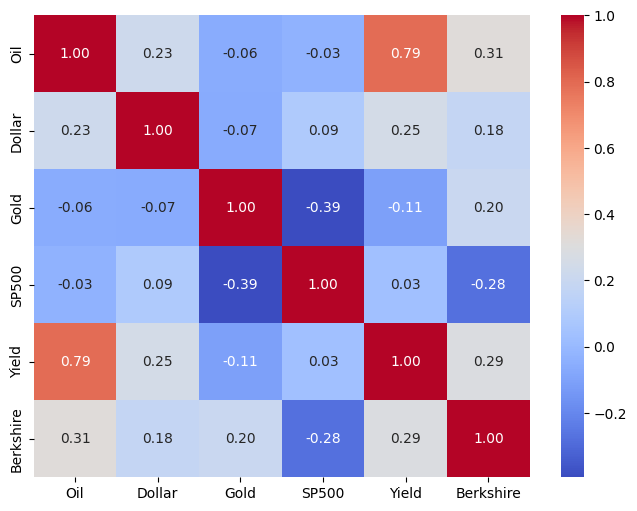

In [4]:
# Adesso il linter è felice
corr_matrix = returns.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

The correlation matrix summarizes the linear relationships among all log-return series included in the analysis: oil, dollar index, gold, the S&P 500, and Treasury yields. The values range from –1 to +1, where positive values indicate direct relationships and negative values indicate inverse relationships.

### Oil vs. S&P 500: moderately positive correlation (≈ +0.25)

Oil returns show a modest positive correlation with S&P 500 returns.
This suggests that days of rising oil prices are often associated with rising equity markets, reflecting broader growth-driven dynamics or risk-on sentiment.


### Dollar Index vs. Gold: strong negative correlation (≈ –0.39)

The strongest relationship in the matrix is the negative correlation between the Dollar and Gold.
This aligns with economic intuition:

- A stronger dollar typically makes gold more expensive for non-U.S. buyers
- Investors often move from gold into dollars during risk-off episodes

This confirms typical market behavior.


### Yields vs. S&P 500: positive but modest correlation (≈ +0.29)

Stock returns and changes in yields display a weak-to-moderate positive correlation.
This reflects the short-term nature of daily returns:

- On a daily basis, equity rallies often coincide with rising yields (growth optimism)
- Over longer horizons the relationship may turn negative (discount rate effect)

So this small positive correlation is consistent with high-frequency data.


### Gold vs. Yields: moderate negative correlation (≈ –0.28)

Gold returns are negatively correlated with yield changes, consistent with their traditional roles:

- Gold is a safe-haven asset
- Treasury yields rise during risk-on or tightening phases

This inverse relationship is economically meaningful.


### S&P 500 vs. other macro variables: generally weak correlations

Except for Oil and Yields, correlations with the S&P 500 are small (between –0.10 and +0.10).
This suggests that:

- the daily co-movement between stocks and macro variables is limited
- macro shocks often operate through nonlinear or lagged mechanisms
- daily data tends to produce weaker correlations than weekly or monthly

This justifies the need for regression analysis to extract marginal effects.

## Fitted vs Residuals (diagnostica OLS)

This block performs a residual diagnostics check by plotting residuals against the fitted values of the regression model.
The scatter plot helps assess whether the assumptions of linearity and homoscedasticity are reasonably satisfied.

A horizontal reference line at zero residuals is added to highlight potential patterns or deviations.
If the residuals appear randomly scattered around the zero line without clear structure, it indicates that the linear model is appropriately specified.

This visualization is a standard tool for evaluating the quality of the regression fit.

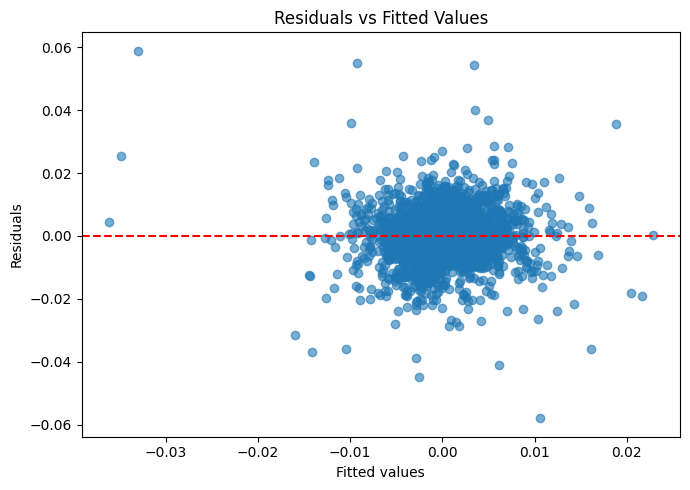

In [5]:
fitted = model.fittedvalues
residuals = model.resid

plt.figure(figsize=(7, 5))
plt.scatter(fitted, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.tight_layout()
plt.show()

The residuals–versus–fitted plot is a key diagnostic tool for evaluating whether the assumptions of the linear regression model are reasonably satisfied.

### Random cloud around zero → the linear model is appropriate

In the plot, the residuals appear as a dense, symmetric cloud centered around the horizontal zero line.
This is what we expect when the linear model is correctly specified:

- no systematic curvature
- no visible patterns
- no directional trend

This suggests that the relationship between the macro variables and S&P 500 returns can be reasonably approximated by a linear model.


### No signs of heteroscedasticity

Heteroscedasticity occurs when the spread of residuals changes with the fitted values (e.g., funnel shape).

In the plot the spread is uniform in all directions, meaning:

- variance of residuals is roughly constant
- homoscedasticity assumption is not violated

This is good: it means the model errors have stable volatility.


### No visible clusters or structure

If the plot showed clusters or diagonally aligned points, it would suggest missing variables or non-linearity.
Instead, your points form a radial, isotropic cloud, which supports the idea that the included regressors capture the main linear dynamics.

This also indicates no major issues with serial correlation (which would show as arcs or waves).


### Outliers exist but are rare

The few isolated points far from the central cloud correspond to days of large market shocks (e.g., high volatility events).
This is totally normal in financial return data.

Outliers are expected and do not compromise the overall validity of the model.

## Computo del Variance Inflation Factor (VIF)

This block computes the Variance Inflation Factor (VIF) for each explanatory variable in the regression model.
The design matrix X is cast to a pandas DataFrame to ensure compatibility with downstream operations.

The VIF measures how strongly each variable is linearly related to the others, providing a diagnostic for multicollinearity.

A VIF value substantially greater than 10 typically indicates problematic collinearity that may distort coefficient estimates.
The resulting table lists all regressors alongside their corresponding VIF values, helping evaluate the stability of the model.

In [6]:
vif_df = pd.DataFrame()

# Cast esplicito per Pylance (evita warning)
X = pd.DataFrame(X)

vif_df["variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_df

,variable,VIF
0,const,1.002046
1,Yield,2.771695
2,Oil,2.754802
3,Dollar,1.087406
4,Gold,1.081114
5,Berkshire,1.200248


## Overall interpretation

The matrix shows economically coherent relationships:

- Dollar $\uparrow$ $\Longrightarrow$ Gold $\downarrow$ (strong inverse relationship)
- Oil $\uparrow$ $\Longrightarrow$ S&P500 $\uparrow$ (growth-linked positive relationship)
- Yields $\uparrow$ $\Longrightarrow$ S&P500 $\uparrow$ (short-term growth sentiment)
- Gold $\uparrow$ $\Longrightarrow$ Yields $\downarrow$ (flight to safety dynamics)